In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import json
import seaborn as sns
import pandas as pd
import json
import shap
from xgboost import XGBRegressor
import warnings
from scipy import stats
from scipy.stats import pearsonr

In [3]:
cell_nums = np.arange(3,97,1)
cell_nums_str = ["{:03d}".format(cell) for cell in cell_nums]
cell_nums_str.remove("083") # shorted cell
cell_nums_str.remove("018") # shorted cell
cells = ["cell_" + cell_num_str for cell_num_str in cell_nums_str]

In [4]:
protocol_features = pd.read_pickle("./data/protocol_features.pkl")

file = "./data/training_set.json"
with open(file,"r") as f:
    train_cells = json.load(f)

file = "./data/test_set.json"
with open(file,"r") as f:
    test_cells = json.load(f)

## Figure 3a

In [4]:
#================Fix the random seed to replicate the same results in this paper
#================ Or you can randomly select, the results are similar
num_seed=1
user_seed=np.random.randint(158,159,size=num_seed)

# ============== Using aging data at 90% SOH to generate the figure
usesoh=0.90
eol_metrics = pd.read_pickle("./data/eol_metrics_soh%s.pkl"%usesoh)

resistance_metrics = ["HPPC 50% discharge 0s","HPPC 50% discharge 3s","HPPC 50% discharge 10s"]
matrix_metrics = ["EFCs (with Diagnostic)","Q_pe","Q_ne","Q_li_cyc","HPPC 50% discharge 0s","HPPC 50% discharge 3s","HPPC 50% discharge 10s"]
features_to_train = ["Average Current","Normalized Current Variance","Maximum Discharge Current",
                     "Relative Charge Fraction","Rest Fraction at High SOC","Rest SOC",
                     "Peak Frequency 1","Peak Frequency 2"]

X_train = protocol_features.loc[train_cells][features_to_train].astype('float64')
X_test = protocol_features.loc[test_cells][features_to_train].astype('float64')

cycling_features = X_train.columns.tolist()

XGBoost

In [5]:
warnings.filterwarnings("ignore")
for i in range(num_seed):
    exec ("shap_importances_df%s = pd.DataFrame(index=matrix_metrics,columns=cycling_features)"%i)

xgbindex=0
for xgbkk in range(num_seed):
    xgbpar = {
                'booster':'gbtree',
                'eta':0.12,
                'max_depth':7,
                'subsample':0.86,
                'min_child_weight':4,
                'colsample_bytree':0.87,
                'n_estimators':140,
                'reg_lambda':20,
                'reg_alpha':0.87,
    }
    # Create a dictionary to hold all the trained models
    xgb_random = {}


    for target in ["EFCs (with Diagnostic)"]:
        y_train = eol_metrics.loc[train_cells,target]
        y_test = eol_metrics.loc[test_cells,target]
        xgb = XGBRegressor(booster='gbtree',reg_alpha=10,reg_lambda=10,importance_type='gain',subsample=0.2,random_state=user_seed[xgbkk])
        xgb.fit(X_train,y_train)
        xgb_random[target] = {}
        xgb_random[target]["Model"] = xgb
        xgb_random[target]["Train RMSE"] = np.sqrt(((xgb.predict(X_train) - y_train)**2).mean())
        xgb_random[target]["Test RMSE"] = np.sqrt(((xgb.predict(X_test) - y_test)**2).mean())
        xgb_random[target]["Train MAPE"] = (xgb.predict(X_train) - y_train).div(y_train).abs().mean()*100
        xgb_random[target]["Test MAPE"] = (xgb.predict(X_test) - y_test).div(y_test).abs().mean()*100
        xgb_random[target]["Feature Importances"] = pd.DataFrame(index=X_train.columns.tolist(),
                                                                data=xgb.feature_importances_,columns=["Importances"])

    for target in ["Q_pe","Q_ne","Q_li_cyc"]:
        y_train = eol_metrics.loc[train_cells,target]
        y_test = eol_metrics.loc[test_cells,target]
        xgb = XGBRegressor(booster='gbtree',importance_type='gain',subsample=0.2,reg_alpha=0,random_state=user_seed[xgbkk])
        xgb.fit(X_train,y_train)
        xgb_random[target] = {}
        xgb_random[target]["Model"] = xgb
        xgb_random[target]["Train RMSE"] = np.sqrt(((xgb.predict(X_train) - y_train)**2).mean())
        xgb_random[target]["Test RMSE"] = np.sqrt(((xgb.predict(X_test) - y_test)**2).mean())
        xgb_random[target]["Train MAPE"] = (xgb.predict(X_train) - y_train).div(y_train).abs().mean()*100
        xgb_random[target]["Test MAPE"] = (xgb.predict(X_test) - y_test).div(y_test).abs().mean()*100
        xgb_random[target]["Feature Importances"] = pd.DataFrame(index=X_train.columns.tolist(),
                                                                data=xgb.feature_importances_,columns=["Importances"])
    for target in resistance_metrics:
        y_train = eol_metrics.loc[train_cells,target]
        y_test = eol_metrics.loc[test_cells,target]
        xgb = XGBRegressor(booster='gbtree',importance_type='gain',subsample=0.2,reg_alpha=0,random_state=user_seed[xgbkk])
        xgb.fit(X_train,y_train)
        xgb_random[target] = {}
        xgb_random[target]["Model"] = xgb
        xgb_random[target]["Train RMSE"] = np.sqrt(((xgb.predict(X_train) - y_train)**2).mean())
        xgb_random[target]["Test RMSE"] = np.sqrt(((xgb.predict(X_test) - y_test)**2).mean())
        xgb_random[target]["Train MAPE"] = (xgb.predict(X_train) - y_train).div(y_train).abs().mean()*100
        xgb_random[target]["Test MAPE"] = (xgb.predict(X_test) - y_test).div(y_test).abs().mean()*100
        xgb_random[target]["Feature Importances"] = pd.DataFrame(index=X_train.columns.tolist(),
                                                                data=xgb.feature_importances_,columns=["Importances"])


    # shap_importances_df = pd.DataFrame(index=matrix_metrics,columns=cycling_features)

    for metric in matrix_metrics:
        cmap = sns.light_palette("#2A00A6",as_cmap=True)
        explainer = shap.TreeExplainer(xgb_random[metric]["Model"])
        shap_values_train = explainer.shap_values(X_train)
        shap_values_test = explainer.shap_values(X_test)
        shap_values = np.concatenate((shap_values_train,shap_values_test))
        # shap_importances_df.loc[metric,cycling_features] = np.abs(shap_values).mean(0)
        eval('shap_importances_df%s'%xgbindex).loc[metric,cycling_features] = np.abs(shap_values).mean(0)

    xgbindex=xgbindex+1



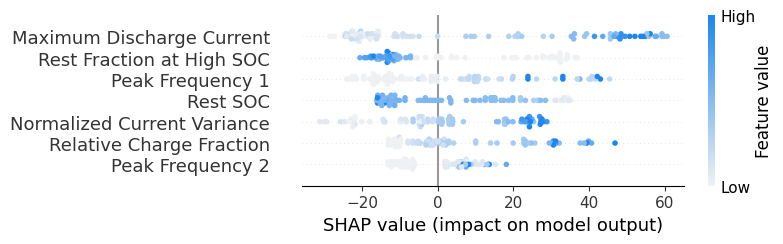

In [6]:
metric = "EFCs (with Diagnostic)"
cmap = sns.light_palette((28/255,134/255,238/255),as_cmap=True)
explainer = shap.TreeExplainer(xgb_random[metric]["Model"])
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)
shap_values = np.concatenate((shap_values_train,shap_values_test))
shap_values = shap_values[:,1:]
X_train=X_train.drop(["Average Current"],axis=1)
X_test=X_test.drop(["Average Current"],axis=1)

shap.summary_plot(shap_values,pd.concat([X_train,X_test]),cmap=cmap,show=False,plot_size=0.15)
plt.gcf().axes[-1].set_aspect(25)
plt.gcf().axes[-1].set_box_aspect(25)

## Figure 3b

In [7]:
#================create random seeds
num_seed=25
user_seed=np.random.randint(1,200,size=num_seed)

totsoh=[0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90]

In [8]:
for tot in totsoh:
    usesoh=tot
    print('SOH =',usesoh)
    eol_metrics = pd.read_pickle("./data/eol_metrics_soh%s.pkl"%usesoh)

    X_train = protocol_features.loc[train_cells][features_to_train].astype('float64')
    X_test = protocol_features.loc[test_cells][features_to_train].astype('float64')


    # Input features
    cycling_features = X_train.columns.tolist()

    # Predicted metrics
    matrix_metrics = ["EFCs (with Diagnostic)","Q_pe","Q_ne","Q_li_cyc","HPPC 50% discharge 0s","HPPC 50% discharge 3s","HPPC 50% discharge 10s"]
    for i in range(num_seed):
        exec ("shap_importances_df%s = pd.DataFrame(index=matrix_metrics,columns=cycling_features)"%i)

    xgbindex=0
    for xgbkk in range(num_seed):
        print('seed =',xgbkk)
        xgbpar = {
                    'booster':'gbtree',
                    'eta':0.12,
                    'max_depth':7,
                    'subsample':0.86,
                    'min_child_weight':4,
                    'colsample_bytree':0.87,
                    'n_estimators':140,
                    'reg_lambda':20,
                    'reg_alpha':0.87,
        }
        # Create a dictionary to hold all the trained models
        xgb_random = {}


        for target in ["EFCs (with Diagnostic)"]:
            y_train = eol_metrics.loc[train_cells,target]
            y_test = eol_metrics.loc[test_cells,target]
            xgb = XGBRegressor(booster='gbtree',reg_alpha=10,reg_lambda=10,importance_type='gain',subsample=0.2,random_state=user_seed[xgbkk])
            xgb.fit(X_train,y_train)
            xgb_random[target] = {}
            xgb_random[target]["Model"] = xgb
            xgb_random[target]["Train RMSE"] = np.sqrt(((xgb.predict(X_train) - y_train)**2).mean())
            xgb_random[target]["Test RMSE"] = np.sqrt(((xgb.predict(X_test) - y_test)**2).mean())
            xgb_random[target]["Train MAPE"] = (xgb.predict(X_train) - y_train).div(y_train).abs().mean()*100
            xgb_random[target]["Test MAPE"] = (xgb.predict(X_test) - y_test).div(y_test).abs().mean()*100
            xgb_random[target]["Feature Importances"] = pd.DataFrame(index=X_train.columns.tolist(),
                                                                    data=xgb.feature_importances_,columns=["Importances"])

        for target in ["Q_pe","Q_ne","Q_li_cyc"]:
            y_train = eol_metrics.loc[train_cells,target]
            y_test = eol_metrics.loc[test_cells,target]
            xgb = XGBRegressor(booster='gbtree',importance_type='gain',subsample=0.2,reg_alpha=0,random_state=user_seed[xgbkk])
            xgb.fit(X_train,y_train)
            xgb_random[target] = {}
            xgb_random[target]["Model"] = xgb
            xgb_random[target]["Train RMSE"] = np.sqrt(((xgb.predict(X_train) - y_train)**2).mean())
            xgb_random[target]["Test RMSE"] = np.sqrt(((xgb.predict(X_test) - y_test)**2).mean())
            xgb_random[target]["Train MAPE"] = (xgb.predict(X_train) - y_train).div(y_train).abs().mean()*100
            xgb_random[target]["Test MAPE"] = (xgb.predict(X_test) - y_test).div(y_test).abs().mean()*100
            xgb_random[target]["Feature Importances"] = pd.DataFrame(index=X_train.columns.tolist(),
                                                                    data=xgb.feature_importances_,columns=["Importances"])
        for target in resistance_metrics:
            y_train = eol_metrics.loc[train_cells,target]
            y_test = eol_metrics.loc[test_cells,target]
            xgb = XGBRegressor(booster='gbtree',importance_type='gain',subsample=0.2,reg_alpha=0,random_state=user_seed[xgbkk])
            xgb.fit(X_train,y_train)
            xgb_random[target] = {}
            xgb_random[target]["Model"] = xgb
            xgb_random[target]["Train RMSE"] = np.sqrt(((xgb.predict(X_train) - y_train)**2).mean())
            xgb_random[target]["Test RMSE"] = np.sqrt(((xgb.predict(X_test) - y_test)**2).mean())
            xgb_random[target]["Train MAPE"] = (xgb.predict(X_train) - y_train).div(y_train).abs().mean()*100
            xgb_random[target]["Test MAPE"] = (xgb.predict(X_test) - y_test).div(y_test).abs().mean()*100
            xgb_random[target]["Feature Importances"] = pd.DataFrame(index=X_train.columns.tolist(),
                                                                    data=xgb.feature_importances_,columns=["Importances"])

    # Analyze the feature importance for a metrics
    # ==============This is done by using SHAP toolbox
        for metric in matrix_metrics:
            cmap = sns.light_palette("#2A00A6",as_cmap=True)
            explainer = shap.TreeExplainer(xgb_random[metric]["Model"])
            shap_values_train = explainer.shap_values(X_train)
            shap_values_test = explainer.shap_values(X_test)
            shap_values = np.concatenate((shap_values_train,shap_values_test))
            eval('shap_importances_df%s'%xgbindex).loc[metric,cycling_features] = np.abs(shap_values).mean(0)

        xgbindex=xgbindex+1


    #=============Average 25 times SHAP results
    shap_df_all=shap_importances_df0.div(shap_importances_df0.sum(axis=1),axis=0).astype('float64')
    for kk in range (1,num_seed):
        shap_df_all=shap_df_all+eval('shap_importances_df%s'%kk).div(eval('shap_importances_df%s'%kk).sum(axis=1),axis=0).astype('float64')
    shap_df=shap_df_all/num_seed
    shap_df.to_csv("./results_save/matrix_"+str(usesoh)+".csv", index=True)

SOH = 0.98
seed = 0
seed = 1
seed = 2
seed = 3
seed = 4
seed = 5
seed = 6
seed = 7
seed = 8
seed = 9
seed = 10
seed = 11
seed = 12
seed = 13
seed = 14
seed = 15
seed = 16
seed = 17
seed = 18
seed = 19
seed = 20
seed = 21
seed = 22
seed = 23
seed = 24
SOH = 0.97
seed = 0
seed = 1
seed = 2
seed = 3
seed = 4
seed = 5
seed = 6
seed = 7
seed = 8
seed = 9
seed = 10
seed = 11
seed = 12
seed = 13
seed = 14
seed = 15
seed = 16
seed = 17
seed = 18
seed = 19
seed = 20
seed = 21
seed = 22
seed = 23
seed = 24
SOH = 0.96
seed = 0
seed = 1
seed = 2
seed = 3
seed = 4
seed = 5
seed = 6
seed = 7
seed = 8
seed = 9
seed = 10
seed = 11
seed = 12
seed = 13
seed = 14
seed = 15
seed = 16
seed = 17
seed = 18
seed = 19
seed = 20
seed = 21
seed = 22
seed = 23
seed = 24
SOH = 0.95
seed = 0
seed = 1
seed = 2
seed = 3
seed = 4
seed = 5
seed = 6
seed = 7
seed = 8
seed = 9
seed = 10
seed = 11
seed = 12
seed = 13
seed = 14
seed = 15
seed = 16
seed = 17
seed = 18
seed = 19
seed = 20
seed = 21
seed = 22
seed = 23
seed =

([<matplotlib.axis.YTick at 0x163c5507f10>,
 [Text(0, 0, 'Peak Frequency $f_2$'),
  Text(0, 1, 'Peak Frequency $f_1$'),
  Text(0, 2, 'Rest SOC'),
  Text(0, 3, 'Rest Fraction at High SOC'),
  Text(0, 4, 'Relative Charge Fraction'),
  Text(0, 5, 'Maximum Discharge Current'),
  Text(0, 6, 'Normalized Current Variance')])

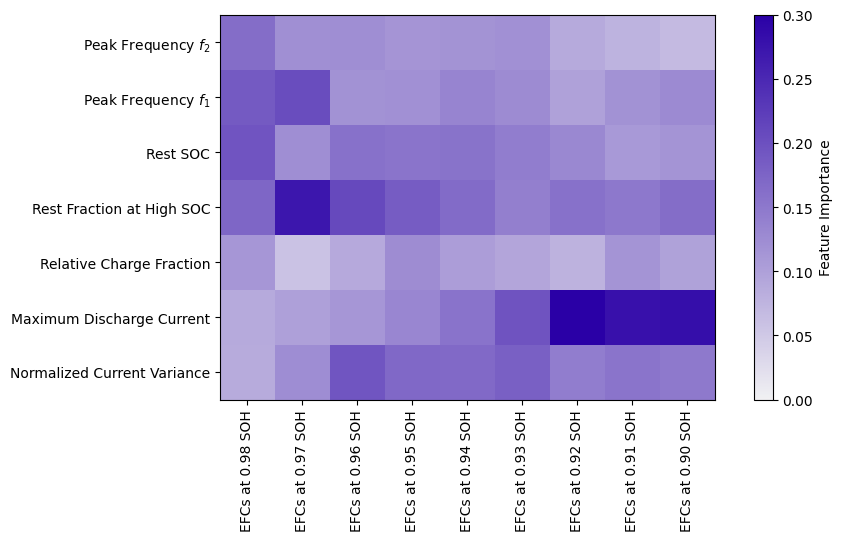

In [9]:
# For each matrix, the y-axis is the end-of-life metrics
# "EFCs (with Diagnostic)","Q_pe","Q_ne","Q_li_cyc","HPPC 50% charge 0s","HPPC 50% charge 3s","HPPC 50% charge 10s"
# Here we only want to obtain the SHAP results for EFCS, so we use values[0,:]

data_Matrix=pd.read_csv("./results_save/matrix_"+str(totsoh[0])+".csv",index_col=0).values[0,:]
for tot in totsoh[1:]:
    addnew=pd.read_csv("./results_save/matrix_"+str(tot)+".csv", index_col=0).values[0,:]
    data_Matrix=np.vstack((data_Matrix,addnew))
data_Matrix=np.rot90(data_Matrix)
redata_Matrix=data_Matrix[:-1,:]
redata_Matrix=redata_Matrix/redata_Matrix.sum(axis=0)
cmap = sns.light_palette("#2A00A6",as_cmap=True)
fig = plt.figure(figsize=(10,5))
plt.imshow(redata_Matrix,cmap=cmap)
plt.colorbar(label="Feature Importance")
plt.clim(0, 0.3)
pxlabel=['EFCs at 0.98 SOH','EFCs at 0.97 SOH','EFCs at 0.96 SOH','EFCs at 0.95 SOH','EFCs at 0.94 SOH','EFCs at 0.93 SOH','EFCs at 0.92 SOH','EFCs at 0.91 SOH','EFCs at 0.90 SOH']
pylabel=['Peak Frequency $f_2$','Peak Frequency $f_1$','Rest SOC','Rest Fraction at High SOC','Relative Charge Fraction','Maximum Discharge Current','Normalized Current Variance']
plt.xticks(range(len(totsoh)),pxlabel,rotation=90)
plt.yticks(range(len(shap_df.columns[:-1])),pylabel)

## Figure 3c

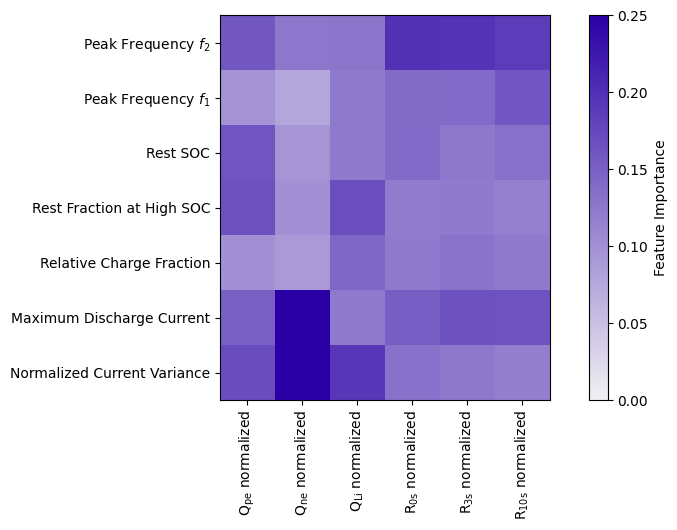

In [10]:
usesoh=0.9
shap_df_fig3c = shap_df.copy()
shap_df_fig3c.drop("EFCs (with Diagnostic)",inplace=True)


shap_df_pt=np.rot90(shap_df_fig3c)
reshap_df_pt=shap_df_pt[:-1,:]
reshap_df_pt=reshap_df_pt/reshap_df_pt.sum(axis=0)
cmap = sns.light_palette("#2A00A6",as_cmap=True)
fig = plt.figure(figsize=(10,5))
plt.imshow(reshap_df_pt,cmap=cmap)
plt.colorbar(label="Feature Importance")
pxlabel=['Q$_\mathdefault{pe}$ normalized','Q$_\mathdefault{ne}$ normalized','Q$_\mathdefault{Li}$ normalized','R$_\mathdefault{0s}$ normalized','R$_\mathdefault{3s}$ normalized','R$_\mathdefault{10s}$ normalized']
pylabel=['Peak Frequency $f_2$','Peak Frequency $f_1$','Rest SOC','Rest Fraction at High SOC','Relative Charge Fraction','Maximum Discharge Current','Normalized Current Variance']
plt.yticks(range(len(shap_df_fig3c.columns[:-1])),pylabel)
plt.xticks(range(len(shap_df_fig3c.index)),pxlabel,rotation=90)
plt.clim(0, 0.25)

## Figure 3d-f

In [11]:
eol_metrics=pd.read_pickle("./data/eol_metrics_soh0.9.pkl")
metadata=pd.read_pickle("./data/metadata.pkl").set_index('cell_name')
merged  = pd.merge(protocol_features, metadata, left_index=True, right_index=True)
cells_todrop =['cell_045','cell_089', 'cell_090', 'cell_093', 'cell_094']
merged  = pd.merge(merged,eol_metrics, left_index=True, right_index=True).drop(cells_todrop) # dropping cells excluded from the analysis
crates = ['Co16','Co10','Co5','Co2']
current_colors_dic = np.vstack([np.array([[240/255,240/255,82/255,1]]),plt.get_cmap('afmhot')(np.flip(np.linspace(0.25,0.6,3)))])
merged

,Average Current,Normalized Current Variance,Maximum Discharge Current,Relative Charge Fraction,Rest Fraction at High SOC,Rest SOC,Peak Frequency 1,Peak Frequency 2,protocol_type,protocol_variant,...,avg_crate_exp,protocol_name,Cycles,EFCs (with Diagnostic),Q_pe,Q_ne,Q_li_cyc,HPPC 50% discharge 0s,HPPC 50% discharge 3s,HPPC 50% discharge 10s
cell_003,0.060343,0.039616,0.101396,0.000000,0.000000,0.086470,0.000018,0.000073,CC,(5% storage),...,0.060343,CC_(5%_storage)_Co10,497.451184,461.25739,0.910071,0.944592,0.865801,1.104006,1.029863,1.001173
cell_004,0.060326,0.039634,0.100298,0.000000,0.000002,0.087134,0.000018,0.000073,CC,(5% storage),...,0.060326,CC_(5%_storage)_Co10,488.989161,453.638826,0.908937,0.942534,0.865711,1.10247,1.030082,1.000999
cell_005,0.060297,0.039663,0.100618,0.000000,0.000000,0.500007,0.000037,0.000073,CC,(50% storage),...,0.060297,CC_(50%_storage)_Co10,467.268025,435.403301,0.920178,0.947501,0.864676,1.102684,1.021693,0.995654
cell_006,0.060288,0.039672,0.100760,0.000000,0.000000,0.500006,0.000037,0.000073,CC,(50% storage),...,0.060288,CC_(50%_storage)_Co10,462.94419,431.739713,0.920512,0.949008,0.86584,1.119538,1.031818,1.003194
cell_007,0.060253,0.039707,0.100199,0.000000,0.397227,1.000000,0.000018,0.000074,CC,(100% storage),...,0.060253,CC_(100%_storage)_Co10,371.348657,348.492233,0.910586,0.944706,0.862975,1.11471,1.040321,1.01183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_088,0.263106,0.888519,2.899958,0.115911,0.335002,0.603611,0.000171,0.000514,Synthetic,3,...,0.263106,Synthetic_3_Co5,699.996529,654.066195,0.911976,0.958259,0.864376,1.045931,0.973552,0.950188
cell_091,0.086125,0.181893,1.261406,0.140701,0.002733,0.629126,0.000056,0.000111,Drive,City1,...,0.086125,Drive_City1_Co10,555.840294,534.736282,0.915226,0.96747,0.867778,1.091796,1.010316,0.984161
cell_092,0.086193,0.182478,1.261383,0.140775,0.002351,0.643670,0.000056,0.000111,Drive,City1,...,0.086193,Drive_City1_Co10,576.974573,554.356413,0.911644,0.967085,0.864851,1.061102,0.984898,0.962432
cell_095,0.093323,0.090003,0.882389,0.075537,0.001110,0.496554,0.000058,0.000116,Drive,City2,...,0.093323,Drive_City2_Co10,503.427628,476.263431,0.918489,0.954729,0.86728,1.092032,1.005061,0.97906


figure 3d

Text(0, 0.5, 'R$_\\mathrm{0s}$ \n (normalized) [-]')

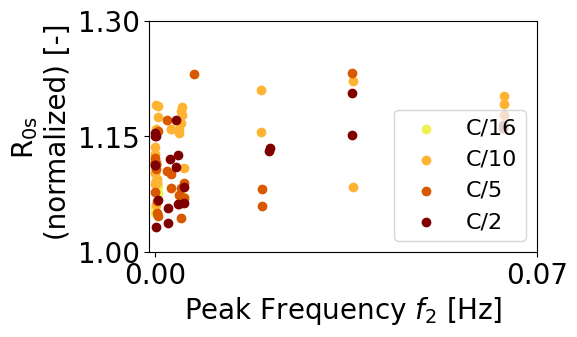

In [12]:
x_metric_name = "Peak Frequency 2"
y_metric_name = "HPPC 50% discharge 0s"

fig,axes=plt.subplots(figsize=(5, 3))
for i,crate in enumerate(crates):
    subdata=merged[merged['avg_Crate']==crate]
    ptx=subdata.loc[:,x_metric_name].values
    pty=subdata.loc[:,y_metric_name].values

    plt.scatter(ptx,pty,color=current_colors_dic[i],label=f"C/{crate[2:]}")
plt.legend(loc='lower right',fontsize=16)

plt.xlim(-0.001,0.07)
plt.xticks([0.000,0.07])
plt.yticks([1.0,1.15,1.3])
axes.tick_params(axis='both', labelsize=20,labelcolor='black')
xlabel_font={'fontsize':20,'color':'black'}
axes.set_xlabel("Peak Frequency $f_\mathrm{2}$ [Hz]",fontdict=xlabel_font)
axes.set_ylabel("R$_\mathrm{0s}$ \n (normalized) [-]",fontdict=xlabel_font)


figure 3e

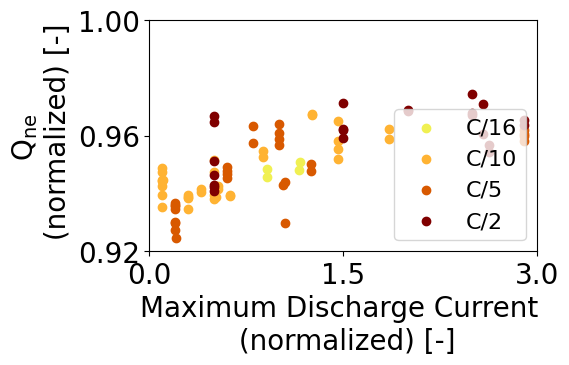

In [13]:
x_metric_name = "Maximum Discharge Current"
y_metric_name = "Q_ne"

fig,axes=plt.subplots(figsize=(5, 3))
for i,crate in enumerate(crates):
    subdata=merged[merged['avg_Crate']==crate]
    ptx=subdata.loc[:,x_metric_name].values
    pty=subdata.loc[:,y_metric_name].values

    plt.scatter(ptx,pty,color=current_colors_dic[i],label=f"C/{crate[2:]}")

plt.xlim(0,3)
plt.xticks([0,1.5,3])
plt.ylim(0.92,1.0)
plt.yticks([0.92,0.96,1.0])
axes.tick_params(axis='both', labelsize=20,labelcolor='black')
xlabel_font={'fontsize':20,'color':'black'}
axes.set_xlabel("Maximum Discharge Current \n (normalized) [-]",fontdict=xlabel_font)
axes.set_ylabel("Q$_\mathrm{ne}$ \n (normalized) [-]",fontdict=xlabel_font)
plt.legend(loc='lower right',fontsize=16)

figure 3f

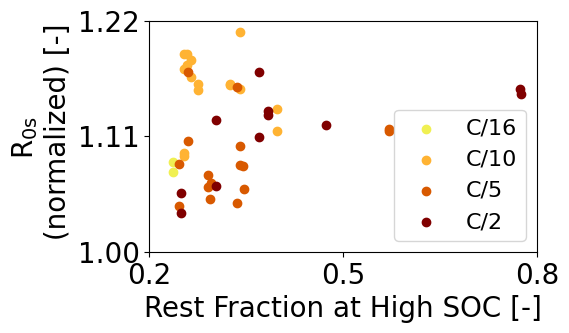

In [14]:
x_metric_name = "Rest Fraction at High SOC"
y_metric_name = "HPPC 50% discharge 0s"

fig,axes=plt.subplots(figsize=(5, 3))
for i,crate in enumerate(crates):
    subdata=merged[merged['avg_Crate']==crate]
    ptx=subdata.loc[:,x_metric_name].values
    pty=subdata.loc[:,y_metric_name].values

    plt.scatter(ptx,pty,color=current_colors_dic[i],label=f"C/{crate[2:]}")

plt.xlim(0.2,0.8)
plt.xticks([0.2,0.5,0.8])
plt.ylim(1,1.22)
plt.yticks([1,1.11,1.22])

axes.tick_params(axis='both', labelsize=20,labelcolor='black')
xlabel_font={'fontsize':20,'color':'black'}

axes.set_xlabel("Rest Fraction at High SOC [-]",fontdict=xlabel_font)
axes.set_ylabel("R$_\mathrm{0s}$ \n (normalized) [-]",fontdict=xlabel_font)
plt.legend(loc='lower right',fontsize=16)